In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as datetime
from bs4 import BeautifulSoup as bs
import requests

now = datetime.datetime.today()
ido = str(now.hour)+':'+str(now.minute)
now = str(now.month)+'/'+str(now.day)+'/'+str(now.year)[2:]

In [2]:
DATA_URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
FILE_C = "time_series_19-covid-Confirmed.csv"
FILE_D = "time_series_19-covid-Deaths.csv"
FILE_R = "time_series_19-covid-Recovered.csv"

def load_data(the_file):
    data = pd.read_csv(the_file)
    lowercase = lambda x: str(x).lower()
    data.rename(lowercase, axis="columns", inplace=True)
    data.rename(columns={'long': 'lon', 'country/region':'country', 'province/state':'state'}, inplace=True)
    data.fillna(0, inplace=True)
    data = data[data['country'] == 'Hungary']
    data = data.iloc[:,4:].T
    data = data[(data.T != 0).any()]
    data.rename(columns={70: 'Eset'}, inplace=True)
    return data

In [3]:
df_d = load_data(DATA_URL + FILE_D) # Halottak
df_r = load_data(DATA_URL + FILE_R) # Gyógyultak
df_c = load_data(DATA_URL + FILE_C) # Esetek
        
df_c

,Eset
3/4/20,2
3/5/20,2
3/6/20,2
3/7/20,4
3/8/20,7
3/9/20,9
3/10/20,9
3/11/20,13
3/12/20,13
3/13/20,19


In [4]:
df = pd.DataFrame()

df['Eset'] = df_c['Eset']
df['Gyógyult'] = df_r['Eset']
df['Halott'] = df_d['Eset']
df.fillna(0, axis=0, inplace= True)
df

,Eset,Gyógyult,Halott
3/4/20,2,0.0,0.0
3/5/20,2,0.0,0.0
3/6/20,2,0.0,0.0
3/7/20,4,0.0,0.0
3/8/20,7,0.0,0.0
3/9/20,9,0.0,0.0
3/10/20,9,0.0,0.0
3/11/20,13,0.0,0.0
3/12/20,13,0.0,0.0
3/13/20,19,0.0,0.0


In [5]:
url='https://koronavirus.gov.hu/'
page = requests.get(url)

soup = bs(page.content, 'html.parser')
c = soup.find_all(class_ = 'number')
eset = int(c[0].text)
gyogyult = int(c[1].text)
halott = int(c[2].text)

dfT = df.T
dfT[now] = [eset, gyogyult, halott]
df = dfT.T
df['Aktív'] = df['Eset']-df['Gyógyult']-df['Halott']
df = df.astype('int')

In [6]:
df['log2'] = np.log2(df['Eset'])
df

,Eset,Gyógyult,Halott,Aktív,log2
3/4/20,2,0,0,2,1.000000
3/5/20,2,0,0,2,1.000000
3/6/20,2,0,0,2,1.000000
3/7/20,4,0,0,4,2.000000
3/8/20,7,0,0,7,2.807355
3/9/20,9,0,0,9,3.169925
3/10/20,9,0,0,9,3.169925
3/11/20,13,0,0,13,3.700440
3/12/20,13,0,0,13,3.700440
3/13/20,19,0,0,19,4.247928


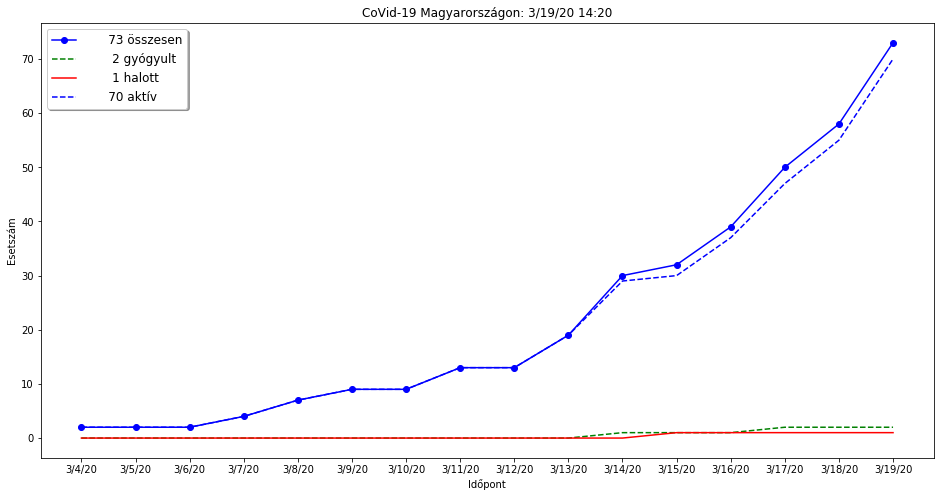

In [7]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)

plt.plot(df.index, df['Eset'], 'bo-',     label=f"{df['Eset'].max():8} összesen")
plt.plot(df.index, df['Gyógyult'], 'g--', label=f"{df['Gyógyult'].max():8} gyógyult")
plt.plot(df.index, df['Halott'], 'r-',    label=f"{df['Halott'].max():8} halott")
plt.plot(df.index, df['Aktív'], 'b--',    label=f"{df['Aktív'].max():8} aktív")
# plt.plot(df.index, df['log2'], label='log2')

# for i,j in df.Eset.items():
#     ax.annotate(str(j), xy=(i, j))

plt.ylabel('Esetszám')
plt.xlabel('Időpont')
plt.title('CoVid-19 Magyarországon: ' + now + ' ' + ido)
plt.legend(shadow=True, fontsize='large')
plt.savefig('huncov.png')
plt.show()
